In [204]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20,10)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [205]:
df1 = pd.read_csv("Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [206]:
df1.shape

(13320, 9)

# Data cleaning

Grouping the data by area-type and aggregating on the basis of count

In [207]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Dropping the less relevent features

In [208]:
df2 = df1.drop(['availability','society', 'balcony', 'area_type'], axis = 'columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [209]:
df2.shape

(13320, 5)

In [210]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

Dropping all the rows which contain null values

In [211]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [212]:
df3.shape

(13246, 5)

In [213]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

Making a new feature 'bhk' which contains the number of bedroom in the house based on the feature 'size'

In [214]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

C:\Users\bajay\AppData\Local\Temp\ipykernel_16764\2222900254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [215]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [216]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [217]:
df3[df3.bhk > 20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [218]:
df3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [219]:
def isFloat(x):
    try:
        float(x)
    except:
        return False
    return True

In [220]:
df3[~df3['total_sqft'].apply(isFloat)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


Function to conver the range in the sqft feature into mean value of the the range. Other format is left as it is.

In [221]:
def convert_sqft_to_num(x):
    token = x.split('-')
    if len(token) == 2:
        return (float(token[0]) + float(token[1]))/2
    try:
        return float(x)
    except:
        return None

In [222]:
convert_sqft_to_num('34.46Sq. Meter')

In [223]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4.head(5)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [224]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [225]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [226]:
df4.head(5)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


# Feature Engineering

In [227]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price'] * 100000/ df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [228]:
len(df5['location'].unique())

1304

In [229]:
df5['location'] = df5['location'].apply(lambda x: x.strip())

In [230]:
# df['label'] & df.label both gives a pandas series either way can be used for data access
df5.location

0        Electronic City Phase II
1                Chikka Tirupathi
2                     Uttarahalli
3              Lingadheeranahalli
4                        Kothanur
                   ...           
13315                  Whitefield
13316               Richards Town
13317       Raja Rajeshwari Nagar
13318             Padmanabhanagar
13319                Doddathoguru
Name: location, Length: 13246, dtype: object

In [231]:
location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending = False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [232]:
locations_less_than_10 = location_stats[location_stats<=10]
locations_less_than_10

location
Basapura                 10
1st Block Koramangala    10
Gunjur Palya             10
Kalkere                  10
Sector 1 HSR Layout      10
                         ..
1 Giri Nagar              1
Kanakapura Road,          1
Kanakapura main  Road     1
Karnataka Shabarimala     1
whitefiled                1
Name: location, Length: 1052, dtype: int64

In [233]:
df5.location = df5.location.apply(lambda x: 'other' if x in locations_less_than_10 else x)
len(df5.location.unique())

242

In [234]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


# Outlier detection and removal

total area of bedroom less than 300sqft. is very unusual, therefore we remove those rows

In [235]:
df5[df5.total_sqft/df5.bhk < 300]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...,...
13277,other,7 Bedroom,1400.0,7.0,218.0,7,15571.428571
13279,other,6 Bedroom,1200.0,5.0,130.0,6,10833.333333
13281,Margondanahalli,5 Bedroom,1375.0,5.0,125.0,5,9090.909091
13303,Vidyaranyapura,5 Bedroom,774.0,5.0,70.0,5,9043.927649


In [236]:
df5.shape

(13246, 7)

In [237]:
df6 = df5[~(df5.total_sqft/df5.bhk < 300)]

In [238]:
df6.shape

(12502, 7)

In [239]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

The below function removes the the outlier whose price per sqft. per location is less than mean - sd or greater than mean + sd 

In [240]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame();
    for key, subdf in df6.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        sd = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - sd)) & (subdf.price_per_sqft < (m + sd))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df7 = remove_pps_outliers(df6)
df7.shape
        

(10241, 7)

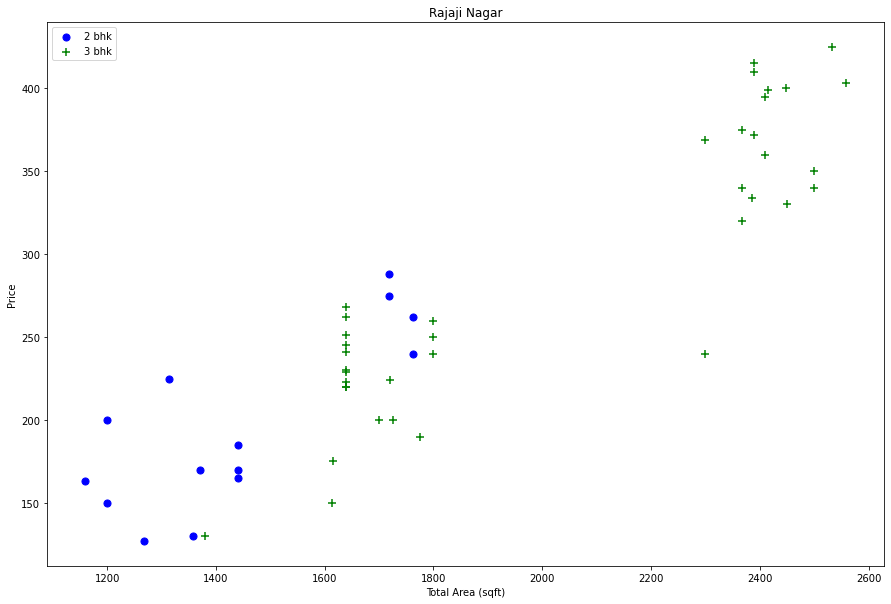

In [241]:
def plot_scatter(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 bhk', s = 50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker = '+', color='green', label='3 bhk', s = 50)    
    plt.xlabel('Total Area (sqft)')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()
    
plot_scatter(df7, 'Rajaji Nagar')

In the above plot we can see that at some points price for 2 bhk plots is more than the price for 3 bhk plot. We consider these to be outliers.

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.***

```{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}```

**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment***

In [242]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk -1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis = 'index')

df8 = remove_bhk_outliers(df7)
df8.shape

(7329, 7)

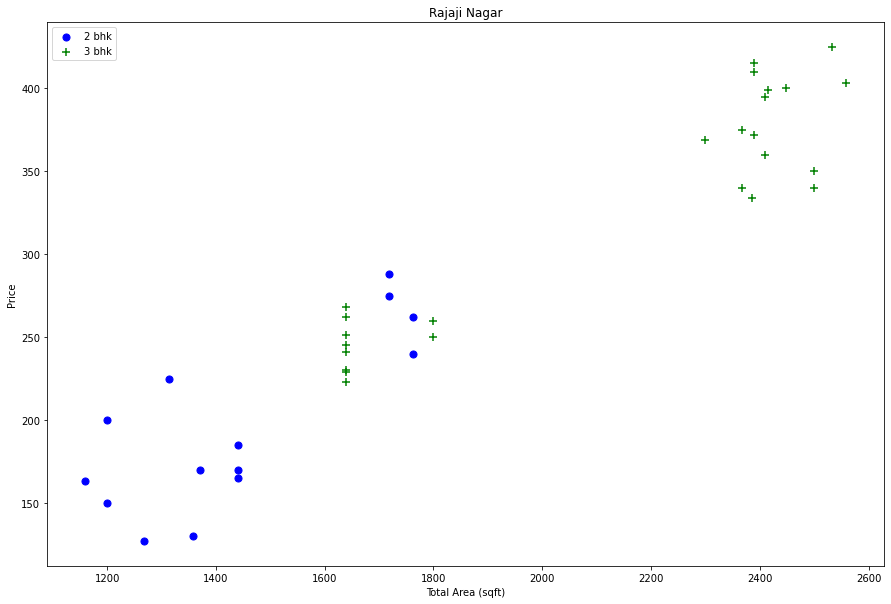

In [243]:
plot_scatter(df8, 'Rajaji Nagar')

Text(0, 0.5, 'Count')

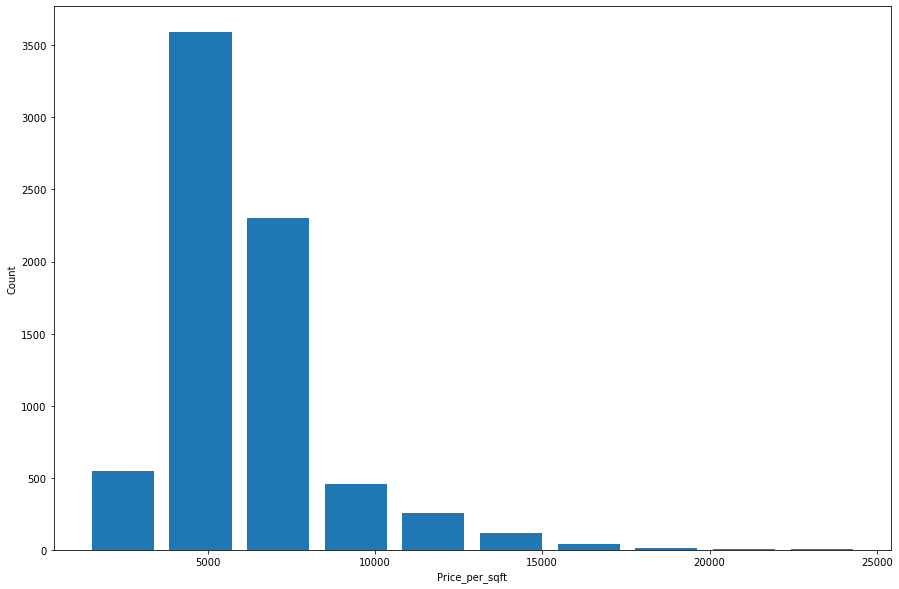

In [244]:
# matplotlib.rcParams('figure.figsize'] = (20,10)
plt.hist(df8.price_per_sqft, rwidth = 0.8)
plt.xlabel('Price_per_sqft')
plt.ylabel('Count')

In [245]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [246]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8486,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8575,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9308,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9639,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

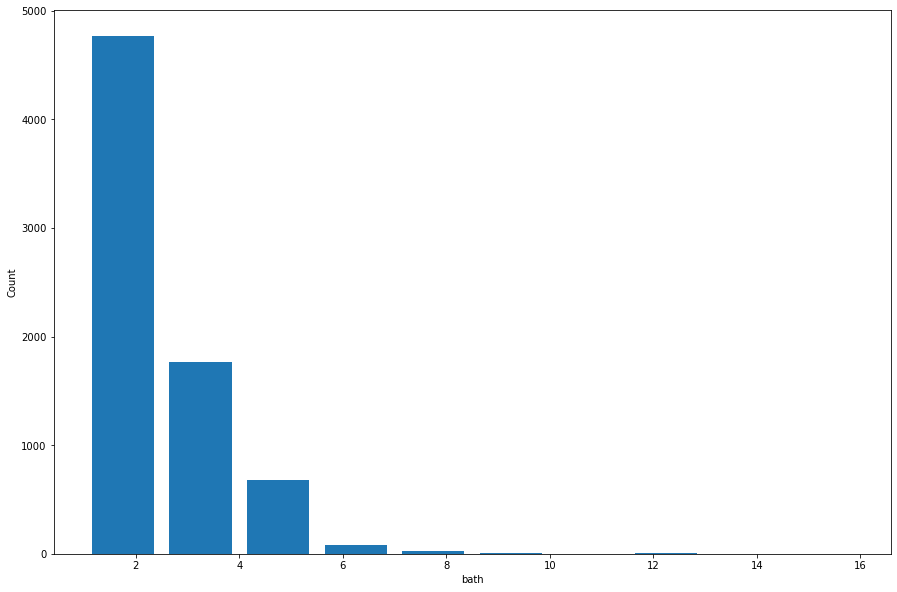

In [247]:
plt.hist(df8.bath, rwidth=0.8)
plt.xlabel('bath')
plt.ylabel('Count')

It is unlikely for homes to have more bathrooms than bedrooms, therefore, we consider the rows for which number of bathrooms exceeding no. of bedroom by 2, as outliers and we remove them.

In [248]:
df8[df8.bath<df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668
...,...,...,...,...,...,...,...
10232,other,2 BHK,1200.0,2.0,70.0,2,5833.333333
10233,other,1 BHK,1800.0,1.0,200.0,1,11111.111111
10236,other,2 BHK,1353.0,2.0,110.0,2,8130.081301
10237,other,1 Bedroom,812.0,1.0,26.0,1,3201.970443


In [249]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7251, 7)

Data Cleaning has been done. Now we can remove some features which are not required for model building, such as size, price_per_sqft.

In [250]:
df10 = df9.drop(['size', 'price_per_sqft'],axis='columns')
df10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [251]:
dummies = pd.get_dummies(df10.location)
dummies.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [252]:
df11 = pd.concat([df10, dummies.drop('other', axis='columns')], axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [253]:
df12 = df11.drop(['location'], axis='columns')
df12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [254]:
df12.shape

(7251, 245)

# Building a model

In [255]:
x = df12.drop('price', axis='columns')

In [256]:
y = df12.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

Splitting the data into train test

In [257]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state = 10)

In [258]:
lnr_model = LinearRegression()
lnr_model.fit(x_train, y_train)
lnr_model.score(x_test, y_test)

0.8452277697874389

## Using K-fold cross validatio to measure accuracy of our LinearRegression model
We can shuffle the split to get better outlook on the scores using shuffleSplit and get cross validation score

In [259]:
cv = ShuffleSplit(n_splits=5, test_size=0.2)
cross_val_score(LinearRegression(), x, y, cv = cv)

array([0.88295813, 0.83610744, 0.87151984, 0.85728233, 0.8544528 ])

## Finding the best model using GridSearchCV

In the following funcion we used Grid Search CV to compare three different models. GridSearchCV gives the parameters for which the model performs the best

In [260]:
def find_best_model_gridsearchcv(x,y):
    algos = {
        'linear_regression' : {
            'model' : LinearRegression(),
            'params': {
                
            }
        },
        'lasso' : {
            'model' : Lasso(),
            'params': {
                'alpha': [1,2],
                'selection':['random', 'cyclic']
            }
        },
        'decision_tree' : {
            'model' : DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['params'], cv = cv, return_train_score=False)
        gs.fit(x.values,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns = ['model','best_score', 'best_params'])
find_best_model_gridsearchcv(x,y)

,model,best_score,best_params
0,linear_regression,0.851562,{}
1,lasso,0.697020,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.696670,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


As can be seen from above cell's output, Linear Regression fits our model the best, so we'll go with Linear Regression

## Testing the model

In [261]:
x.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

In [262]:
np.where(x.columns=='2nd Phase Judicial Layout')[0][0]


5

In [263]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(x.columns==location)[0][0]
    
    data = np.zeros(len(x.columns))
    data[0] = sqft
    data[1] = bath
    data[2] = bhk
    if loc_index>0:
        data[loc_index] = 1
        
    return lnr_model.predict([data])

In [264]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)[0]

C:\Users\bajay\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


83.49904677209898

# Exporting the model to .pickle file

In [265]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lnr_model,f)

# Exporting column information to a json file

In [266]:
import json
columns = {
    'data_columns' : [col.lower() for col in x.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))